In [123]:
import numpy as np
from sklearn.cluster import DBSCAN
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.matlib
from sklearn.neighbors import NearestNeighbors
import pandas as pd

In [29]:
def distance_neighbors(signal):
    nn = NearestNeighbors(4) # 4 nearest neighbors
    nbrs =nn.fit(signal.reshape(-1,1))
    distances, indices = nbrs.kneighbors(signal.reshape(-1,1))
    distances = sorted(distances[:,-1],reverse=True)
    return distances
    


References : https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve

In [30]:
def find_knee(distances):
    nPoints = len(distances)
    allCoord = np.vstack((range(nPoints), distances)).T
    np.array([range(nPoints), distances])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    return distances[idxOfBestPoint]

In [156]:
def detect_outliers(ts, ys,plot=True,auto=True):
    distances = distance_neighbors(ys)
    knee_point = find_knee(distances)
    mark = distances.index(knee_point)
   
    fig,ax = plt.subplots(figsize=[10,4])
   
    ax.plot(distances)
    ax.annotate("knee",(mark,knee_point),arrowprops=dict(facecolor='black', shrink=0.05))
    plt.show()
    if auto ==True:
        db = DBSCAN(eps=knee_point,min_samples=4)
        clusters = db.fit(ys.reshape(-1,1))
        cluster_labels = clusters.labels_
        outliers = np.where(cluster_labels ==-1)
    if auto == False:
        eps = input('Enter the value for eps')
        db = DBSCAN(eps=eps,min_samples=4)
        clusters = db.fit(ys.reshape(-1,1))
        cluster_labels = clusters.labels_
        outliers = np.where(cluster_labels ==-1)
    if plot == True:
        color= ['red' if l == -1 else 'green' for l in cluster_labels]
        fig,ax = plt.subplots(figsize=[10,4]) 
        ax.scatter(ts,ys,color=color,marker='x')
        plt.show()
    return outliers
    

In [157]:
t = np.linspace(-1, 1, 200, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + np.real(np.exp(-7*(t-0.4)**2)*np.exp(1j*2*np.pi*2*(t-0.4)))

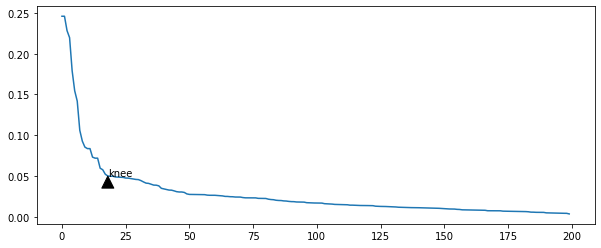

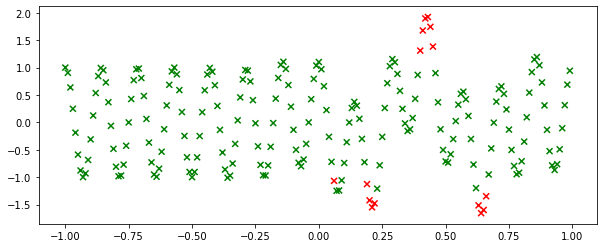

(array([106, 119, 120, 121, 122, 140, 141, 142, 143, 144, 145, 163, 164,
        165, 166]),)

In [158]:
detect_outliers(t,sig)

In [159]:
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

#Add outliers

outliers_start = np.mean(signal)+5*np.std(signal)
outliers_end = np.mean(signal)+6*np.std(signal)
outlier_values = np.arange(outliers_start,outliers_end,0.1)
index = np.random.randint(0,len(signal),6)
print(index)
signal_out = signal
for i,ind in enumerate(index):
    signal_out[ind] = outlier_values[i]


[1597 1023 1541  572 1543  829]


In [160]:
signal = pd.Series(signal_out)

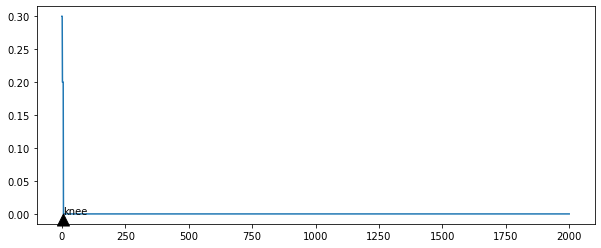

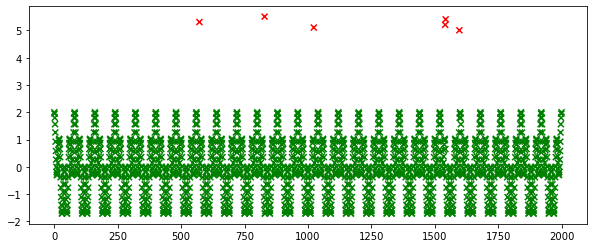

In [161]:
outlier_index = detect_outliers(signal.index,signal.values)

Mixed Frequency Signal

In [162]:
freqs=[1/20,1/80,1/200]
time=np.arange(2000)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)
series=pd.Series(signal,index=time)

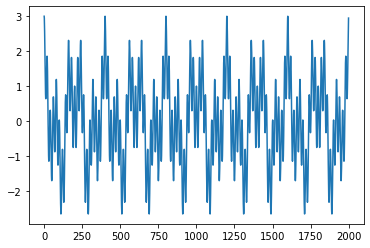

In [163]:
plt.plot(series)

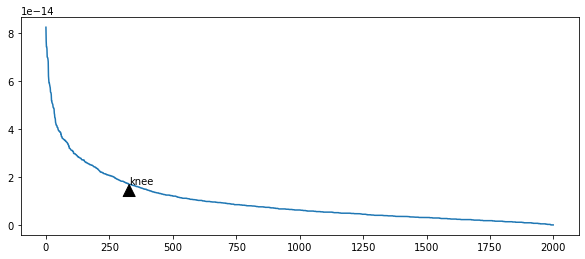

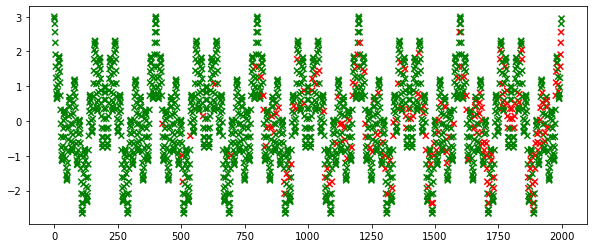

(array([ 426,  504,  506,  536,  586,  634,  696,  794,  815,  824,  825,
         834,  843,  856,  857,  866,  875,  884,  906,  907,  916,  925,
         934,  944,  953,  957,  984,  985, 1016, 1017, 1034, 1035, 1044,
        1062, 1067, 1076, 1085, 1094, 1113, 1117, 1126, 1135, 1144, 1145,
        1154, 1163, 1172, 1176, 1177, 1186, 1194, 1195, 1204, 1222, 1226,
        1227, 1245, 1254, 1259, 1273, 1277, 1286, 1295, 1304, 1305, 1314,
        1323, 1332, 1336, 1337, 1346, 1355, 1364, 1369, 1382, 1386, 1387,
        1396, 1405, 1414, 1433, 1437, 1446, 1455, 1456, 1464, 1465, 1474,
        1478, 1483, 1487, 1492, 1496, 1497, 1506, 1514, 1515, 1524, 1542,
        1546, 1547, 1556, 1574, 1593, 1597, 1606, 1615, 1624, 1625, 1632,
        1656, 1657, 1658, 1659, 1666, 1675, 1676, 1677, 1684, 1685, 1686,
        1687, 1694, 1695, 1703, 1704, 1705, 1706, 1713, 1714, 1715, 1722,
        1723, 1732, 1733, 1757, 1758, 1766, 1767, 1768, 1769, 1777, 1784,
        1785, 1786, 1787, 1795, 1796, 

In [164]:
detect_outliers(series.index,series.values)

In [165]:
def colored_noise(alpha, t, f0=None, m=None, seed=None):
    ''' Generate a colored noise timeseries
    Args:
        alpha (float): exponent of the 1/f^alpha noise
        t (float): time vector of the generated noise
        f0 (float): fundamental frequency
        m (int): maximum number of the waves, which determines the
            highest frequency of the components in the synthetic noise
    Returns:
        y (array): the generated 1/f^alpha noise
    References:
        Eq. (15) in Kirchner, J. W. Aliasing in 1/f(alpha) noise spectra: origins, consequences, and remedies.
            Phys Rev E Stat Nonlin Soft Matter Phys 71, 066110 (2005).
    '''
    n = np.size(t)  # number of time points
    y = np.zeros(n)

    if f0 is None:
        f0 = 1/n  # fundamental frequency
    if m is None:
        m = n//2

    k = np.arange(m) + 1  # wave numbers

    if seed is not None:
        np.random.seed(seed)

    theta = np.random.rand(int(m))*2*np.pi  # random phase
    for j in range(n):
        coeff = (k*f0)**(-alpha/2)
        sin_func = np.sin(2*np.pi*k*f0*t[j] + theta)
        y[j] = np.sum(coeff*sin_func)

    return y

In [167]:
time = np.arange(2001)
signal = colored_noise(1, time, seed=2333)

colored_noise_signal = pd.Series(signal, index=time)

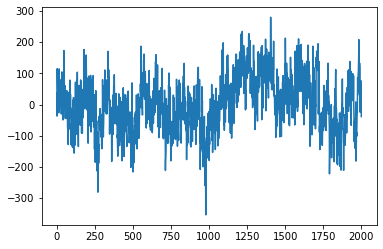

In [171]:
plt.plot(colored_noise_signal)

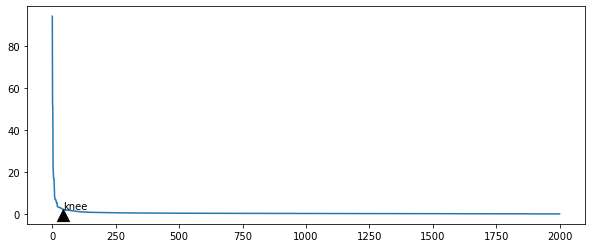

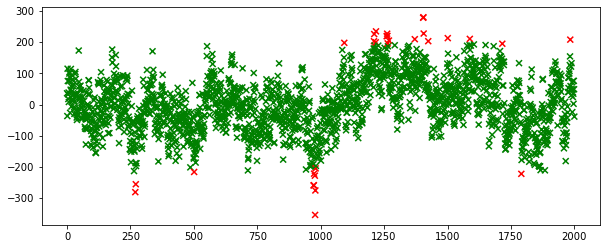

(array([ 269,  271,  501,  972,  973,  974,  977,  978,  979,  980, 1093,
        1210, 1211, 1217, 1218, 1260, 1262, 1263, 1264, 1269, 1371, 1404,
        1405, 1406, 1424, 1501, 1588, 1716, 1791, 1984]),)

In [170]:
detect_outliers(colored_noise_signal.index,colored_noise_signal.values)

In [185]:
def generate_signal(kind):
    series = pd.Series()
    if (kind == 'Constant'):
        time = np.arange(2001)
        f = 1/50
        signal = np.cos(2*np.pi*f*time)

        series = pd.Series(signal, index=time)
    
    elif kind =='Two_Constant':
        time1 = np.arange(1000)
        f1 = 1/50
        signal1 = np.cos(2*np.pi*f1*time1)

        time2 = np.arange(1000, 2001)
        f2 = 1/100
        signal2 = np.cos(2*np.pi*f2*time2)

        signal = np.concatenate([signal1, signal2])
        time = np.concatenate([time1, time2])

        series = pd.Series(signal, index=time)
    
    elif kind == 'Two_Close':
        time1 = np.arange(1000)
        f1 = 1/50
        signal1 = np.cos(2*np.pi*f1*time1)

        time2 = np.arange(1000, 2001)
        f2 = 1/55
        signal2 = np.cos(2*np.pi*f2*time2)

        signal = np.concatenate([signal1, signal2])
        time = np.concatenate([time1, time2])

        series = pd.Series(signal, index=time)
        return series
    
    elif kind == 'Variant':
        freqs=[1/20,1/80,1/200]
        time=np.arange(2000)
        signals=[]
        for freq in freqs:
            signals.append(np.cos(2*np.pi*freq*time))
        signal=sum(signals)
        series=pd.Series(signal,index=time)


        
        
    return series

In [173]:
def add_white_noise (signal,snr):
    np.random.seed(2333)
    time = signal.index
    sig_var = np.var(signal)
    noise_var = sig_var/snr
    white_noise = np.random.normal(0, np.sqrt(noise_var), size=np.size(signal))
    signal_noise = signal + white_noise
    series = pd.Series(signal_noise, index=time)
    return series

In [175]:
constant_signal = generate_signal('Constant')

/home/pratheek/anaconda3/envs/pyleoclim/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [177]:
signal_with_noise = add_white_noise(constant_signal,0.6)

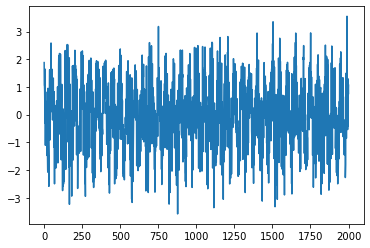

In [178]:
plt.plot(signal_with_noise)

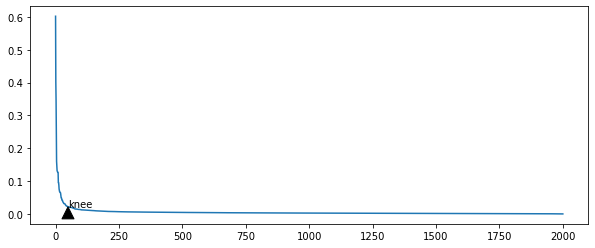

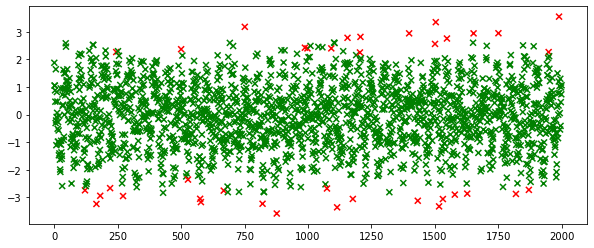

(array([ 121,  166,  181,  220,  244,  271,  500,  527,  575,  578,  668,
         751,  821,  877,  988,  998, 1075, 1092, 1115, 1156, 1177, 1205,
        1207, 1399, 1433, 1501, 1504, 1517, 1532, 1548, 1579, 1628, 1653,
        1751, 1820, 1871, 1949, 1990]),)

In [180]:
detect_outliers(signal_with_noise.index,signal_with_noise.values)

In [181]:
signal_with_noise = add_white_noise(constant_signal,1)

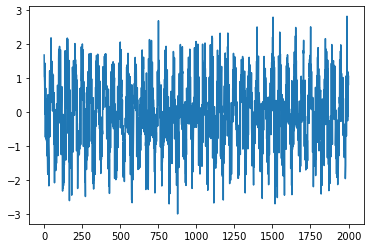

In [182]:
plt.plot(signal_with_noise)

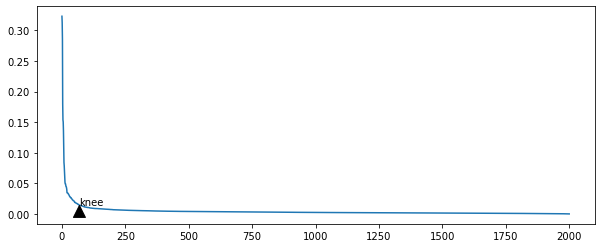

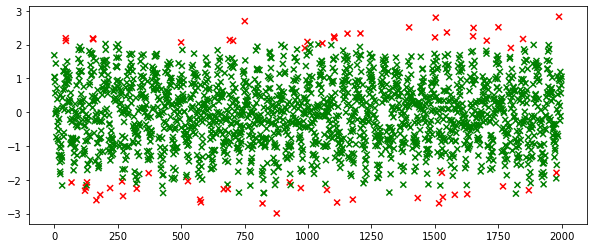

(array([  45,   46,   68,  121,  124,  129,  152,  154,  166,  181,  220,
         267,  271,  325,  372,  500,  527,  575,  578,  668,  684,  692,
         705,  751,  821,  877,  928,  972,  988,  998, 1057, 1075, 1103,
        1105, 1115, 1156, 1177, 1207, 1399, 1433, 1501, 1504, 1517, 1528,
        1532, 1548, 1579, 1628, 1651, 1653, 1705, 1751, 1769, 1800, 1848,
        1871, 1980, 1990]),)

In [184]:
detect_outliers(signal_with_noise.index,signal_with_noise.values)

In [186]:
two_constant = generate_signal('Two_Constant')

/home/pratheek/anaconda3/envs/pyleoclim/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [187]:
two_constant_with_noise = add_white_noise(two_constant,0.4)

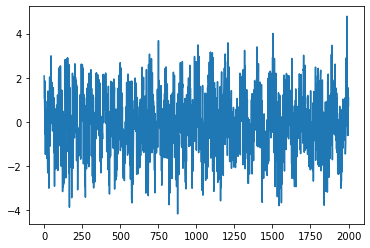

In [188]:
plt.plot(two_constant_with_noise)

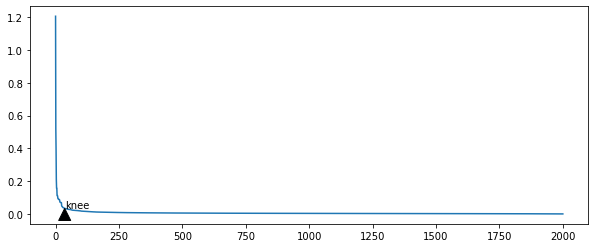

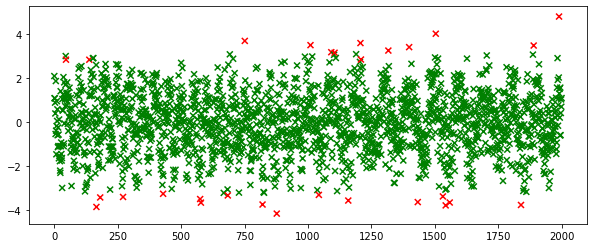

(array([  46,  138,  166,  181,  271,  429,  575,  578,  684,  751,  821,
         877, 1010, 1043, 1092, 1105, 1159, 1207, 1209, 1317, 1399, 1433,
        1504, 1532, 1543, 1559, 1840, 1890, 1990]),)

In [189]:
detect_outliers(two_constant_with_noise.index,two_constant_with_noise.values)

In [190]:
import pyleoclim as pyleo

[  63  812 1814  437  804 1940]


Text(0, 0.5, 'Value')

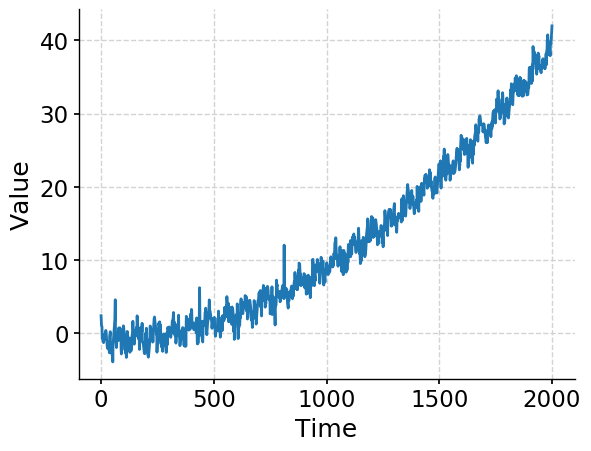

In [191]:
# Generate a mixed signal with known frequencies
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

#Add outliers

outliers_start = np.mean(signal)+5*np.std(signal)
outliers_end = np.mean(signal)+6*np.std(signal)
outlier_values = np.arange(outliers_start,outliers_end,0.1)
index = np.random.randint(0,len(signal),6)
print(index)
signal_out = signal
for i,ind in enumerate(index):
    signal_out[ind] = outlier_values[i]

# Add a non-linear trend
slope = 1e-5
intercept = -1
nonlinear_trend = slope*time**2 + intercept
signal_trend = signal + nonlinear_trend
#signal_trend = signal_out + nonlinear_trend

#Add white noise
sig_var = np.var(signal)
noise_var = sig_var / 2 #signal is twice the size of noise
white_noise = np.random.normal(0, np.sqrt(noise_var), size=np.size(signal))
signal_noise = signal_trend + white_noise

#Remove data points
del_percent = 0.4
n_del = int(del_percent*np.size(time))
deleted_idx = np.random.choice(range(np.size(time)), n_del, replace=False)
time_unevenly =  np.delete(time, deleted_idx)
signal_unevenly =  np.delete(signal_noise, deleted_idx)


#Plot
plt.plot(time_unevenly,signal_unevenly)
plt.xlabel('Time')
plt.ylabel('Value')

In [193]:
ts = pyleo.Series(time=time_unevenly,value=signal_unevenly)


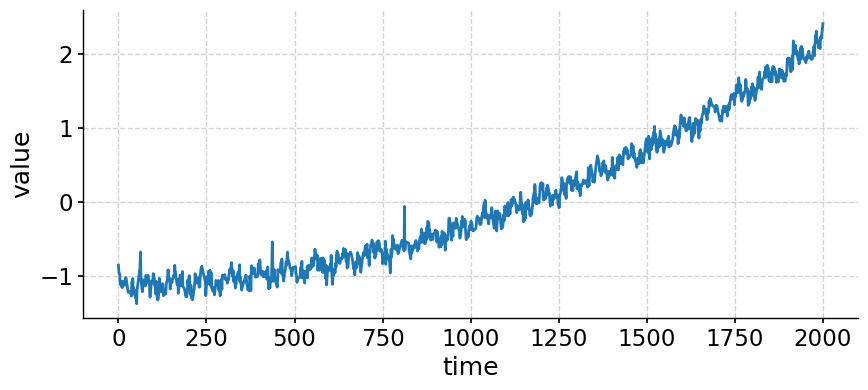

In [194]:
ts_std = ts.standardize()
fig,ax = ts_std.plot()

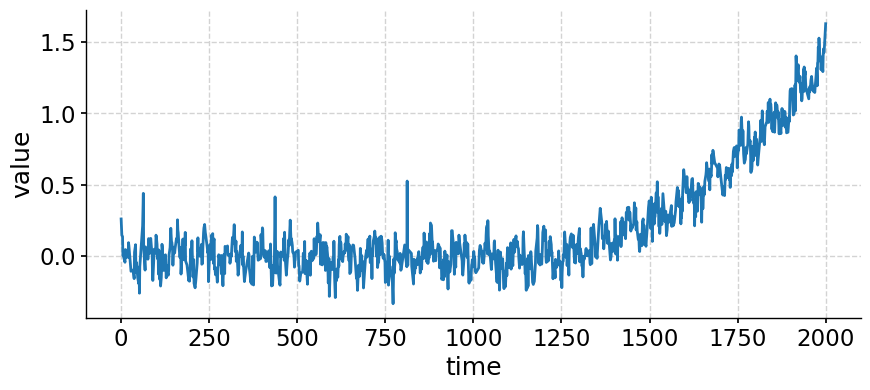

In [195]:
ts_detrended = ts_std.detrend(method='emd')
fig,ax = ts_detrended.plot()

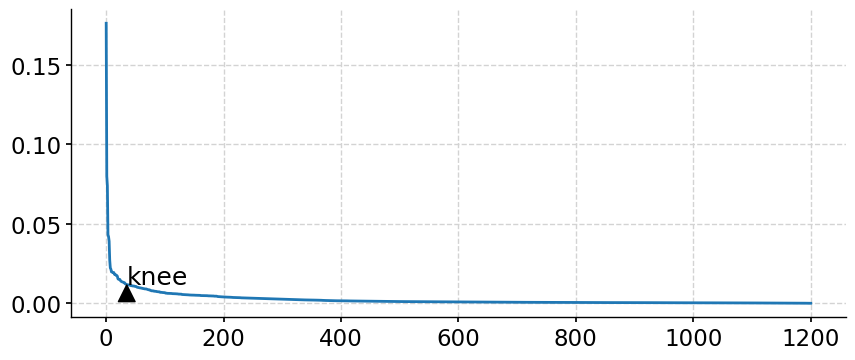

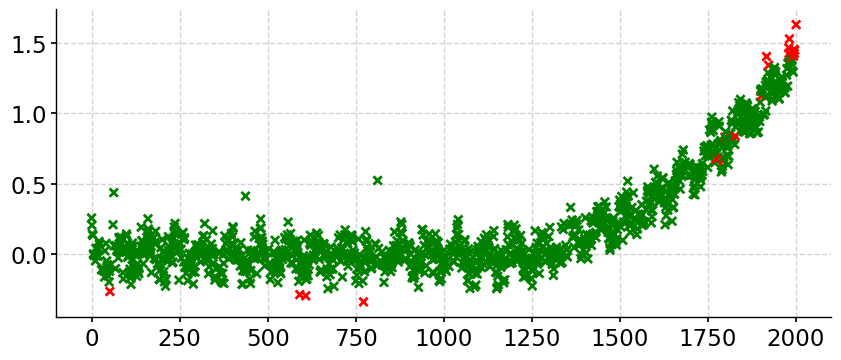

(array([  27,  347,  357,  452, 1051, 1061, 1065, 1068, 1087, 1137, 1146,
        1149, 1186, 1187, 1188, 1189, 1191, 1196, 1197, 1198, 1199, 1200]),)

In [196]:
detect_outliers(ts_detrended.time,ts_detrended.value)